# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/",one_hot=True)

ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'

In [3]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [8]:
# train_images

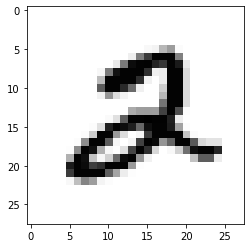

In [7]:
plt.imshow(train_images[5].reshape(28,28),cmap='Greys')

# The Networks

Useful Links:

https://stackoverflow.com/questions/45307072/using-leaky-relu-in-tensorflow

### Activation Function

## The Generator

In [9]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [10]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [14]:
G = generator(z)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


### Discriminator 

In [15]:
D_output_real , D_logits_real = discriminator(real_images)

In [16]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [17]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [18]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [19]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [20]:
D_loss = D_real_loss + D_fake_loss

In [21]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [22]:
learning_rate = 0.001

In [23]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [24]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [25]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [26]:
# Save a sample per epoch
samples = []

In [28]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = train_images.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = train_images.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
#         saver.save(sess, './models/500_epoch_model.ckpt')

AttributeError: 'numpy.ndarray' object has no attribute 'num_examples'

In [29]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epoch_model.ckpt


In [30]:
plt.imshow(samples[0].reshape(28,28),cmap='Greys')

IndexError: list index out of range